# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params
theta = 0.1 

move_control = 0.9

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 0

infection_seed_size = 100

hospitalization_duration = 14.0

alpha = [0.1, 0.3, 0.2]



# sdh with pei movement

### plots sdh model by prevalence
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/sdh_params.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv 
### creates sirh_sdh
python -m epymorph run --ipm sdh --mm icecube --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv 

In [4]:
from epymorph.run import run
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.simulation import Simulation
from epymorph.world import Population 

from shapely.geometry import Point, Polygon
from matplotlib.pyplot import xlabel
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import pandas as pd
import numpy as np
import os

%matplotlib inline

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')



Loading requirements:
[✓] IPM (sdh)
[✓] MM (centroids)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/sdh_params.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2505 geo nodes
|####################| 100% 
Runtime: 1112.841s
Displaying chart: p0


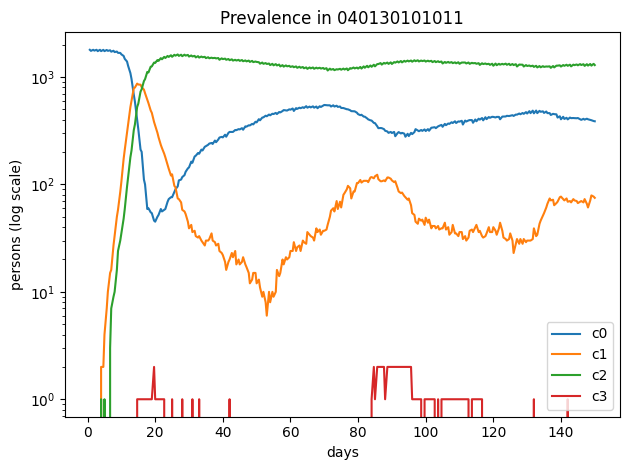

Writing output to file: /Users/alexandernez/Desktop/Github/Epymorph/scratch/output_files/sirh.csv
Done


In [6]:
exit_code = run(
    ipm_name = 'sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/sdh_params.toml",
    out_path = f"{dir}/output_files/sirh.csv",
    chart = 'p0',
    profiling=False
)

# Creates the Maricopa County dataframe

In [7]:
geo = 'https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/04_ARIZONA/04013/tl_2020_04013_bg10.zip'
maricopa = gpd.read_file(geo)

# Creates the Social Determinate of Health dataframe

In [38]:
with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)

sdh_df = pd.DataFrame({k: list(v) for k, v in data.items()})
lat_lon_df = pd.DataFrame(sdh_df["centroid"].to_list(), columns=['Lon', 'Lat'])

sdh_df['gamma'] = 0 
sdh_df['gamma 0'] = 0.0290022

sdh_df['beta'] = 0
sdh_df['alpha 0'] = 0.1
sdh_df["alpha 1"] = 0.8
sdh_df["alpha 2"] = 0.2    

for i in range(len(sdh_df)):
    # Alpha values used to control beta
    a0 = sdh_df['alpha 0'][i]
    a1 = sdh_df['alpha 1'][i]
    a2 = sdh_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = sdh_df["average_household_size"][i]
    x2 = sdh_df["pop_density_km2"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = sdh_df["median_income"][i]
    h2 = sdh_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - sdh_df["average_household_size"].mean()) / sdh_df["average_household_size"].std()
    scale_x2 = (x2 - sdh_df["pop_density_km2"].mean()) / sdh_df["pop_density_km2"].std()
    scale_h1 = (h1 - sdh_df["median_income"].mean()) / sdh_df["median_income"].std()
    scale_h2 = (h2 - sdh_df["tract_gini_index"].mean()) / sdh_df["tract_gini_index"].std()
    
    # Calculate gamma based on Alpha values used to control gamma
    g0 = sdh_df["gamma 0"][i]
  
    # Calculate the value of beta and gramma for each nodes
    beta = np.exp((a0 + (a1 * scale_x1) * (a2 * scale_x2)))
    gamma = g0 * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))

    # Saved the calculate value of beta and gamma in its respected node index
    sdh_df.loc[i, ['beta', 'gamma']] = [beta, gamma]


In [15]:
sdh_df.head()

,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,tract_gini_index,gamma,gamma 0,beta,alpha 0,alpha 1,alpha 2
0,040130101011,1791,"[-111.770772219983, 33.7692433720249]",50.5,"[358, 110, 671, 374, 194, 84]",99219,90125800,2.33,99.301764,0.4423,0.000581,0.0029,1.235965,0.1,0.8,0.2
1,040130101012,2007,"[-111.720000642927, 33.741096326025]",63.9,"[162, 0, 423, 460, 559, 403]",127614,155213500,2.15,68.730308,0.4423,0.000297,0.0029,1.295627,0.1,0.8,0.2
2,040130101013,1264,"[-111.666997365524, 33.7239868229889]",70.8,"[0, 22, 0, 249, 655, 338]",80742,73694600,1.83,183.139061,0.4423,0.000855,0.0029,1.387046,0.1,0.8,0.2
3,040130101021,1139,"[-111.490977560506, 33.715337047738]",58.9,"[58, 52, 361, 362, 258, 48]",105987,89511200,2.04,0.474269,0.5439,0.000114,0.0029,1.340105,0.1,0.8,0.2
4,040130101022,1487,"[-111.850574119318, 33.8260427149521]",62.8,"[110, 82, 202, 500, 452, 141]",128523,128439900,2.20,125.178297,0.5439,0.000062,0.0029,1.274440,0.1,0.8,0.2


# Creates the IPM dataframe

In [26]:
header_names = ['days', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

df = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']

df.groupby(['tracts']).sum().drop(labels = 'days', axis = 'columns').sort_index()

,S,I,R,H,S->I,I->R,I->H,H->R,R->S,I & H->R
tracts,,,,,,,,,,
0,142875,26008,362473,108,3391,3268,4,3,1952,3271
1,161106,30244,401533,234,3854,3754,12,10,2274,3764
2,101032,19261,260858,183,2404,2301,8,9,1390,2310
3,92859,16526,233961,73,2187,2117,3,4,1261,2121
4,123707,22220,297520,277,2737,2739,13,13,1658,2752
...,...,...,...,...,...,...,...,...,...,...
2500,2054,368,5023,1,39,49,0,0,8,49
2501,8239,1464,19128,4,142,116,0,0,71,116
2502,6378,1219,15718,7,163,95,0,0,60,95


In [27]:
plot_df = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
plot_df['I & H->R'] = plot_df['I->R'] + plot_df['H->R']

plot_df.groupby(['days']).sum().drop(labels= 'tracts', axis='columns').sort_index()

,S,I,R,H,S->I,I->R,I->H,H->R,R->S,I & H->R
days,,,,,,,,,,
0,4319102,8057,1651,0,0,1651,0,0,0,1651
1,4318758,7757,2294,1,350,649,1,0,6,649
2,4318488,6780,3539,3,295,1270,2,0,25,1270
3,4318052,6647,4107,4,449,581,1,0,13,581
4,4317330,6216,5258,6,753,1182,2,0,31,1182
...,...,...,...,...,...,...,...,...,...,...
295,1031893,158257,3138009,651,13890,13364,24,21,11484,13385
296,1027593,159355,3141215,647,27628,26504,26,30,23328,26534
297,1025394,159996,3142768,652,13873,13212,20,15,11674,13227


,days,tracts,S,I,R,H,S->I,I->R,I->H,H->R,R->S,I & H->R
0,0,0,1791,0,0,0,0,0,0,0,0,0
1,0,1,2007,0,0,0,0,0,0,0,0,0
2,0,2,1264,0,0,0,0,0,0,0,0,0
3,0,3,1139,0,0,0,0,0,0,0,0,0
4,0,4,1487,0,0,0,0,0,0,0,0,0


# Combines all the dataframe to create a geopandas dataframe

In [28]:

data = [df, sdh_df, lat_lon_df, maricopa]
geo_df = pd.concat(data, axis =1)
gpd_df = gpd.GeoDataFrame(geo_df)

gpd_df.to_csv(dir + '/utility/gpd.csv')

### Plotting result

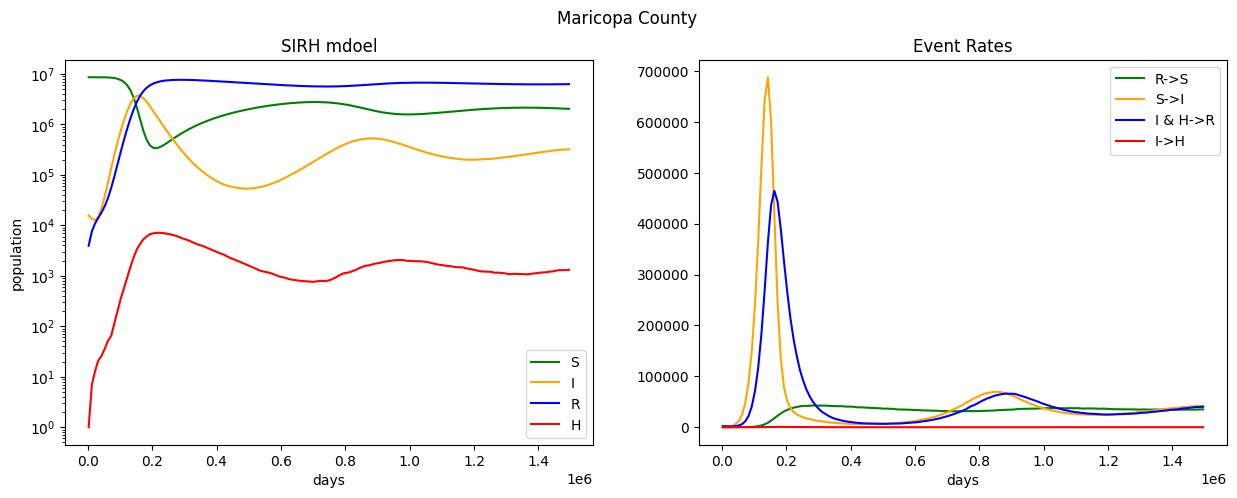

In [11]:
# Get current axis
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = plot_df[['days', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = plot_df[['days', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['days'] // 2, sort=False).sum()
Events = Events.groupby(Events['days'] // 2, sort=False).sum()
# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            x='days',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[0],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            x='days',
            y=event_rate[i],
            color=color[i], 
            ax=axes[1],
            title = 'Event Rates')    
# show the plot
plt.show()



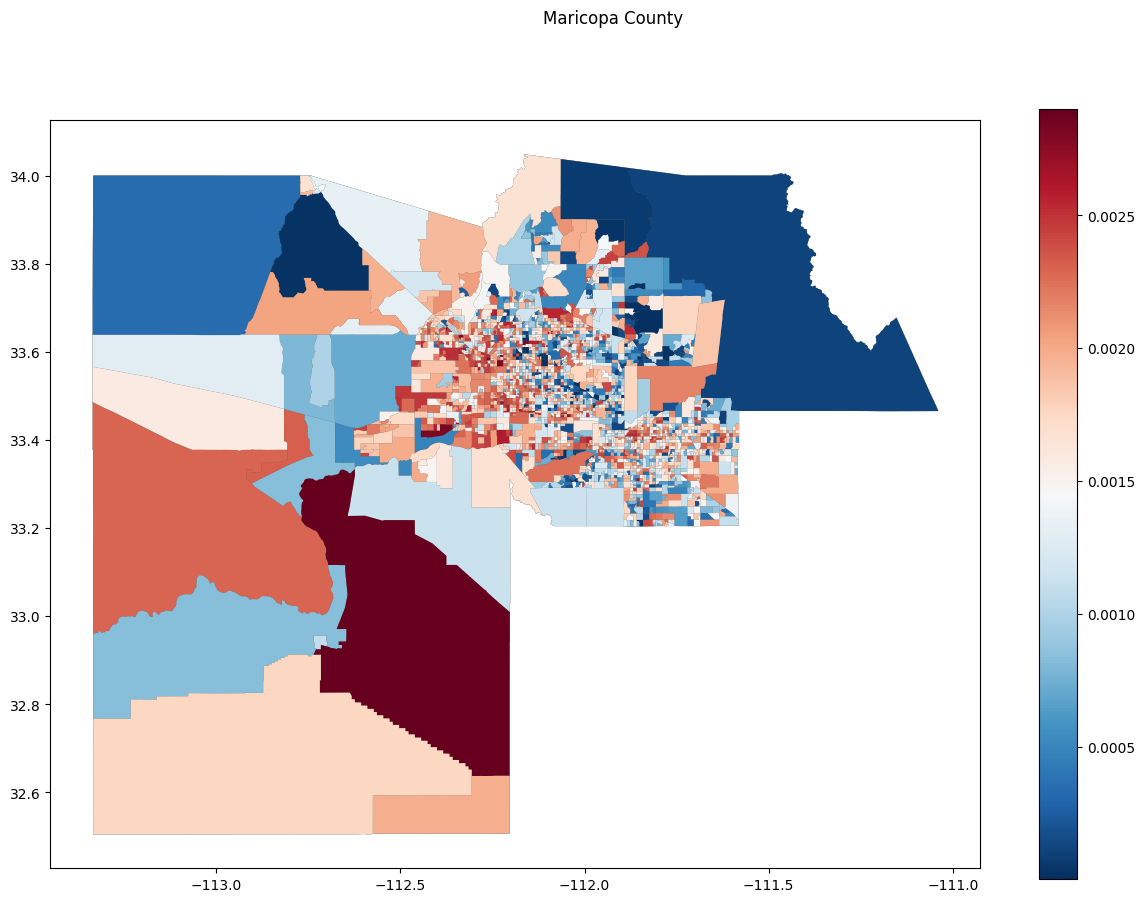

In [41]:
value = 'gamma'

fig, ax = plt.subplots(figsize=(15,10))
# add .shp mapfile to axes
fig.suptitle('Maricopa County')

maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

gpd_df.plot(
    ax = ax, 
    edgecolor = 'black', 
    column = value, 
    legend = True, 
    cmap='RdBu_r',
    vmin = geo_df[value].min(), 
    vmax = geo_df[value].max(),
    linewidth = 0.01
    )


plt.show()


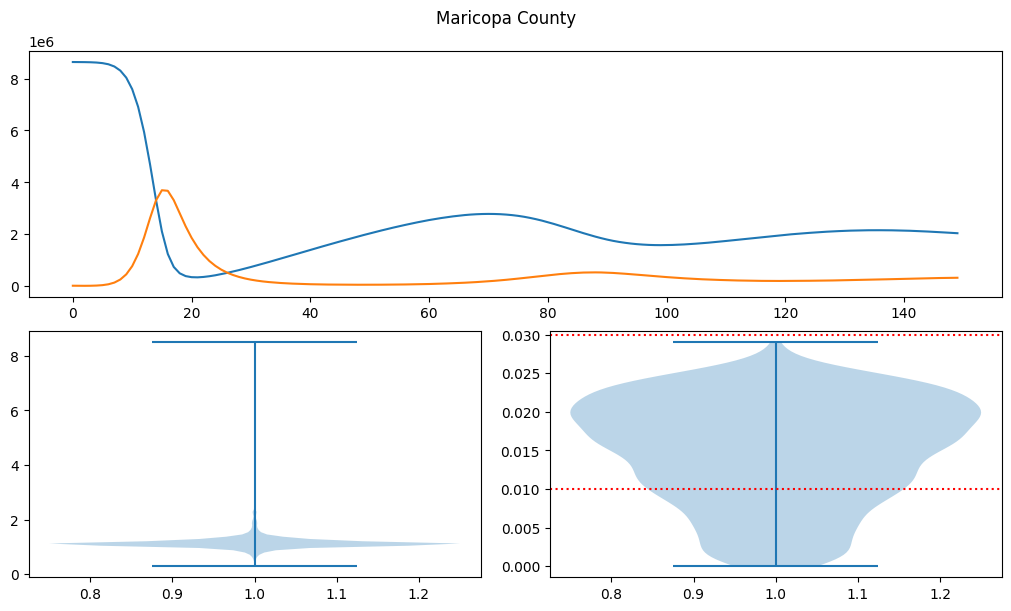

In [39]:
fig = plt.figure(figsize=(10,6), layout="constrained")
spec = fig.add_gridspec(2, 2)
fig.suptitle('Maricopa County')

ax0 = fig.add_subplot(spec[0, :])
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])

ax0.plot(sirh_compartment['S'])
ax0.plot(sirh_compartment['I'])
ax10.violinplot(sdh_df['beta'])
ax11.violinplot(sdh_df['gamma'])
plt.axhline(y = 0.01, color = 'r', linestyle = 'dotted')
plt.axhline(y = 0.03, color = 'r', linestyle = 'dotted')

plt.show()
